In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets

import pathlib
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
def activation_layer(activation:str):

    if activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)


In [3]:
def normalization_layer(normalization: str,
                      num_channels: int, dim:int):
    if dim == 2:
        if normalization == 'BN':
            return nn.BatchNorm2d(num_channels)
    elif dim == 3:
        if normalization == 'BN':
            return nn.BatchNorm3d(num_channels)


In [4]:
def pooling_layer(pooling:str, dim:int):
    if dim == 2:
        if pooling == "max":
            return nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        #if pooling == 'stride':
           # return nn.Conv2d()
    if dim == 3:
        if pooling == "max":
            return nn.MaxPool3d(kernel_size=2,stride=2,padding=0)


In [6]:
def conv_layer(in_chs, out_chs, kernel_size, stride, padding, dim):
    if dim == 2:
        return nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding)
    elif dim == 3:
        return nn.Conv3d(in_chs, out_chs, kernel_size, stride, padding)

In [7]:
def up_sample_layer(up_sample,in_chs = None, out_chs = None, kernel_size = 2, stride = 2, dim = 3):
    if up_sample == 'transposed':
        if dim == 2:
            return nn.ConvTranspose2d(in_chs, out_chs, kernel_size,stride)
        elif dim == 3:
            return nn.ConvTranspose3d(in_chs, out_chs, kernel_size,stride)
    else:
        return nn.Upsample(scale_factor=2, mode=up_sample)

In [8]:
def Cat(tensor1, tensor2):
    
    x = torch.cat((tensor1, tensor2), 1)

    return x

In [9]:
class DownBlock(nn.Module):
    """
    left part of the U shape.
    the repeated application of two 3 × 3 × 3 3D convolution layers, 
    each followed by a batch normalization (BN) and a leaky rectified
    """

    def __init__(self,chs=[1,16,32,64,128],
               
                 pooling: str = "max",
                 kernel_size: int = 3,
                 stride:int = 1,
                 padding: int = 1,
                 activation: str = 'leaky',
                 normalization: str = 'BN',
                 dim: int = 2):
        super().__init__()

        self.chs = chs
        #self.out_channels = chs[::-1]
        self.pooling = pooling
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        
        self.activation_layer = activation_layer(self.activation)
        #self.normalization_layer = normalization_layer(normalization=self.normalization, num_channels=out_chs,
                                           #dim=self.dim)       
        self.pool = pooling_layer(pooling = self.pooling, dim=self.dim)
        
        self.tensor_to_cat = []
        
        self.num_level = len(self.chs)-1
        self.levels = []
        # conv layers
        for i in range(self.num_level):
            in_chs = self.chs[i]
            out_chs = self.chs[i+1]
            norm_layer = normalization_layer(normalization=self.normalization, num_channels=out_chs,
                                           dim=self.dim)
            conv_layer1 = conv_layer(in_chs, out_chs, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
            conv_layer2 = conv_layer(out_chs, out_chs, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
            level = nn.Sequential(
                conv_layer1,
                self.activation_layer,
                norm_layer,
                conv_layer2,
                self.activation_layer,
                norm_layer
            )
            self.levels.append(level)
        




    def forward(self, x):
        #print(x.shape)
        
        for i in range(self.num_level-1):
            x = self.levels[i](x)
            #x = self.pool(y)
            self.tensor_to_cat.append(x)
            stride_layer = conv_layer(self.chs[i+1], self.chs[i+1], kernel_size = self.kernel_size, stride = 2, padding = self.padding, 
                                          dim = self.dim)
            x = stride_layer(x)
            
            norm_layer = normalization_layer(normalization=self.normalization, num_channels=self.chs[i+1],
                                           dim=self.dim)
            x = norm_layer(x)
            x = self.activation_layer(x)
            #print(x.shape)

        x = self.levels[-1](x)

        return x, self.tensor_to_cat


In [ ]:
x = torch.randn(1,1,128,128,32)
model = DownBlock(chs=[1,16,32,64,128],
                 #concatenate = True,
                 pooling = "max",
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation = 'leaky',
                 normalization = 'BN',
                 dim= 3)
y,ts = model(x)



In [ ]:
y.shape

In [10]:
def crop(down_level, up_level):
    """
    the input down_level is each level's last tensor on the left (down) side. e.g. [1,1,256,256,64]; up_level is the first
    tensor on the right (up) side.
    Center-crops the encoder_layer to the size of the decoder_layer,
    so can catanate encoder layer to decoder layer
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if down_level.shape[2:] != up_level.shape[2:]:
        down_shape = down_level.shape[2:]
        up_shape = up_level.shape[2:]
#down_shape should bigger than up_shape
        if down_level.dim() == 4:  # 2D
            down_level = encoder_layer[
                            :,
                            :,
                            ((down_shape[0] - up_shape[0]) // 2):((down_shape[0] + up_shape[0]) // 2),
                            ((down_shape[1] - up_shape[1]) // 2):((down_shape[1] + up_shape[1]) // 2)
                            ]
        elif down_level.dim() == 5:  # 3D
            down_level = down_level[
                            :,
                            :,
                            ((down_shape[0] - up_shape[0]) // 2):((down_shape[0] + up_shape[0]) // 2),
                            ((down_shape[1] - up_shape[1]) // 2):((down_shape[1] + up_shape[1]) // 2),
                            ((down_shape[2] - up_shape[2]) // 2):((down_shape[2] + up_shape[2]) // 2),
                            ]
    return down_level, up_level


catanate -> add

In [29]:
class UpBlock(nn.Module):
    """

    """

    def __init__(self,
                 chs = [1,16,32,64,128],
                 concatenate:bool = True,
                 Crop:bool=True,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 3,
                 up_sample: str = 'nearest'
                 ):
        super().__init__()

        self.chs = chs[::-1]
        self.concatenate = concatenate
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        self.up_sample = up_sample
        self.Crop = Crop
        

    
        self.activation_layer = activation_layer(self.activation)
        #self.normalization_layer = normalization_layer(normalization=self.normalization, num_channels=out_chs,
                                           #dim=self.dim)       
        self.up_sample_layer = up_sample_layer(up_sample = self.up_sample)
        
        
        self.num_level = len(self.chs)-1


            
    def forward(self, tensor_to_cat, x_from_down):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        x = x_from_down
        
        if self.up_sample != 'transposed':
            
            for i in range(self.num_level-1):
                in_chs = self.chs[i]
                out_chs = self.chs[i+1]    
                
                conv_layer0 = conv_layer(in_chs, in_chs//2, kernel_size = 3, stride = 1, padding = 1, #to half the channels when up sampling
                                          dim = self.dim)
                
                x = self.up_sample_layer(x)  # double the image size
                x = conv_layer0(x) #half the channels
                
                if self.Crop:
                    cropped_tensor, up_tensor = crop(tensor_to_cat[i], x)  # cropping
                    x = Cat(cropped_tensor,up_tensor)
                else:
                    x = Cat(tensor_to_cat[-i-1],x)
                    
            #conv-BN-ACTIVATION
                conv_layer1 = conv_layer(in_chs, out_chs, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
                conv_layer2 = conv_layer(out_chs, out_chs, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
                norm_layer = normalization_layer(normalization=self.normalization, num_channels=out_chs,
                                           dim=self.dim)
                x = conv_layer1(x)
                x = norm_layer(x)
                x = self.activation_layer(x)
                x = conv_layer2(x)
                x = norm_layer(x)
                x = self.activation_layer(x)
                
            conv_layer_end = conv_layer(self.chs[-2], self.chs[-1], kernel_size = self.kernel_size, stride = self.stride, padding = self.padding, 
                                          dim = self.dim)
            x = conv_layer_end(x)

        return x


In [ ]:
model1 = UpBlock(chs = [1,16,32,64,128],
                 concatenate= True,
                 Crop=False,
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation= 'leaky',
                 normalization = "BN",
                 dim = 3,
                 up_sample= 'nearest')

In [ ]:
z=model1(ts,y)

In [ ]:
z.shape

In [30]:
class UNet(nn.Module):
    def __init__(self,
                 chs = [1,16,32,64,128],
                 concatenate:bool = True,
                 Crop:bool=True,
                 pooling = "max",
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation: str = 'leaky',
                 normalization: str = "BN",
                 dim: int = 3,
                 up_sample: str = 'nearest'
                 ):
        super().__init__()

        self.chs = chs

        self.pooling = pooling
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.activation = activation
        self.normalization = normalization
        self.dim = dim
        #self.chs = chs[::-1]
        self.concatenate = concatenate
        self.up_sample = up_sample
        self.Crop = Crop
        
        
        self.UpBlock = UpBlock(chs = self.chs,
                 concatenate= self.concatenate,
                 Crop=self.Crop,
                 kernel_size = self.kernel_size,
                 stride = self.stride,
                 padding = self.padding,
                 activation= self.activation,
                 normalization = self.normalization,
                 dim = self.dim,
                 up_sample= self.up_sample)
        
        self.DownBlock = DownBlock(chs=self.chs,
                 pooling = self.pooling,
                 kernel_size = self.kernel_size,
                 stride = self.stride,
                 padding = self.padding,
                 activation = self.activation,
                 normalization = self.normalization,
                 dim= self.dim)    
        
    def forward(self,x):
        x_from_down, tensor_to_cat = self.DownBlock(x)
        x = self.UpBlock(tensor_to_cat,x_from_down)
            
        return x
                
            

In [14]:
x1 = torch.randn(1,1,128,128,32)


In [31]:
unet = UNet(chs = [1,16,32,64,128],
                 concatenate= True,
                 Crop=False,
                 pooling = "max",
                 kernel_size = 3,
                 stride = 1,
                 padding = 1,
                 activation= 'leaky',
                 normalization = "BN",
                 dim= 3,
                 up_sample = 'nearest')

In [16]:
result = unet(x1)

In [17]:
result.shape

torch.Size([1, 1, 128, 128, 32])

start to try real image data

In [18]:
from scipy.io import loadmat

In [19]:
P = loadmat('xcat.mat')

In [20]:
p = P['data']

In [21]:
p1 = p[:,:,:,3]

In [22]:
p1 = p[:,:,256:256+32,3]

In [23]:
p1.shape

(256, 256, 32)

In [12]:
type(p1)

numpy.ndarray

In [24]:
P1= torch.from_numpy(p1)

In [25]:
P1.shape

torch.Size([256, 256, 32])

In [26]:
P1 = P1.unsqueeze(0)
P1 = P1.unsqueeze(0)

In [27]:
P1.shape

torch.Size([1, 1, 256, 256, 32])

In [32]:
z = unet(P1)

In [33]:
z.shape

torch.Size([1, 1, 256, 256, 32])

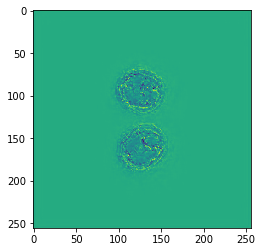

In [36]:
output= z[0,0,:,:,0]
output = output.detach().numpy()
plt.imshow(output)

training error and test error plot